+ Reference : https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Variational_Inference_with_Normalizing_Flows

In [1]:
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
torch.manual_seed(0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define Gaussian Log PDF

### Gaussian log PDF : $$\sum_{j=1}^{n}-\frac{1}{2} \log{2\pi \odot z_{i,j}^{2}}$$      

+ $q_{\phi}(\cdot)$ 함수를 정의 
 > 다시 말해, 입력 데이터 $x$ 분포의 적절한 manifold를 찾기 위해 우리가 쉽게 접근할 수 있는 Gaussian으로 출발

In [2]:
def gaussian_log_pdf(z):   
    """
    Arguments:
    ----------
        - z : a batch of m data points (size : m by data_dim)
    """
    return -.5 * (torch.log(torch.tensor([math.pi * 2], device=z.device)) + z ** 2).sum(1)


## Define PlanarFlow     
### PlanarFlow : Invertible Linear-time Transformation     
### $$f(z) = z + u \cdot h(w^{T}z + b)$$

In [3]:
class PlanarFlow(nn.Module):
    
    def __init__(self, data_dim):
        super().__init__()
        
        self.u = nn.Parameter(torch.rand(data_dim))
        self.w = nn.Parameter(torch.rand(data_dim))
        self.b = nn.Parameter(torch.rand(1))
        self.h = nn.Tanh()
        self.h_prime = lambda z : (1-self.h(z) ** 2)
        
        
    def constrained_u(self):
        """
        Constrain the parameters u to ensure invertibility
        """
        wu = torch.matmul(self.w.T, self.u)
        m = lambda x: -1 + torch.log(1+torch.exp(x))
        
        return self.u + (m(wu) - wu) * (self.w / (torch.norm(self.w) ** 2 + 1e-15))
       

    def forward(self, z):
        u = self.constrained_u()
        hidden_units = torch.matmul(self.w.T, z.T) + self.b
        x = z + u.unsqueeze(0) * self.h(hidden_units).unsqueeze(-1)
        psi = self.h_prime(hidden_units).unsqueeze(0) * self.w.unsqueeze(-1)
        log_det = torch.log((1 + torch.matmul(u.T, psi)).abs() + 1e-15)
        
        return x, log_det
    

## Define Normalizing Flow      

In [5]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, flow_length, data_dim):
        super().__init__()
        
        self.layers = nn.Sequential(
            *(PlanarFlow(data_dim) for _ in range(flow_length)))
    
    def forward(self, z):
        
        log_jacobians = 0
        
        for layer in self.layers:
            z, log_jacobian = layer(z)
            log_jacobians += log_jacobian
        
        return z, log_jacobians

In [4]:
class FreeEnergyBound(nn.Module):

    def __init__(self, density):
        super().__init__()

        self.density = density

    def forward(self, zk, log_jacobians):

        # sum_of_log_jacobians = sum(log_jacobians)
        # return (-sum_of_log_jacobians - safe_log(self.density(zk))).mean()
        return (-log_jacobians - torch.log(self.density(zk) + 1e-7)).mean()

# Train Loop

### flow_log_density : $\ln{q_k(z_k)} = \ln{q_0(z0)} - |jacobian|$     

+ hyper-parameter인 **log_density**는 **실제 로그 분포**를 의미하며 밑에 있는 plot을 그리기 위한 파라미터

In [6]:
def train(flow, optimizer, iterations, log_density, batch_size, data_dim):
    
    train_loss = []
    
    for iteration in tqdm(range(iterations)):
        
        
        # Generate new samples from the flow
        z0 = torch.randn(batch_size, data_dim).to(device)
        zk, log_jacobian = flow(z0)
        
        # Evaluate the exact and approxiamtd densities
        flow_log_density = gaussian_log_pdf(z0) - log_jacobian
        exact_log_density = log_density(zk).to(device)  # 실제 분포
        
        # Compute the Loss
        reverse_KL_divergence = (flow_log_density - exact_log_density).mean()

        optimizer.zero_grad()
        loss = reverse_KL_divergence
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    return train_loss

## Train hyper-parameter

In [7]:
flow_length = 32
batch_size = 4096
data_dim = 2
iterations = 20000

flow = NormalizingFlow(flow_length, data_dim).to(device)
optimizer = optim.RMSprop(flow.parameters(), lr=1e-5, momentum=0.9)

# Plot flow density

In [8]:
def plot_flow_density(flow, ax, lims=np.array([[-4,4],[-4,4]]), cmap='hot', title=None,
                      nb_point_per_dimension=1000):
    
    # Sample broadly from the latent space
    latent_space_boundaries = np.array([[-15,15], [-15,15]])
    xx, yy = np.meshgrid(
        np.linspace(latent_space_boundaries[0][0], latent_space_boundaries[0][1],nb_point_per_dimension),
        np.linspace(latent_space_boundaries[1][0], latent_space_boundaries[1][1],nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1,1), yy.reshape(-1,1)), axis=1), dtype=torch.float)
    
    # Generate data points and evaluate thier densities
    zk, log_jacobian = flow(z.to(device))
    final_log_prob = gaussian_log_pdf(z) - log_jacobian.cpu()
    qk = torch.exp(final_log_prob)
       
    ax.set_xlim(lims[0][0], lims[0][1])
    ax.set_ylim(lims[1][0], lims[1][1])
    ax.pcolormesh(
        zk[:,0].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension),
        zk[:,1].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension) * -1,
        qk.detach().data.reshape(nb_point_per_dimension,nb_point_per_dimension),
        cmap=cmap)

    
    if title is not None:
        plt.title(title, fontsize=22)

# Plot exact density

In [9]:
def plot_exact_density(ax, exact_log_density, lims=np.array([[-4, 4], [-4, 4]]), nb_point_per_dimension=100,
                       cmap="hot", title=None):
    xx, yy = np.meshgrid(np.linspace(lims[0][0], lims[0][1], nb_point_per_dimension),
                         np.linspace(lims[1][0], lims[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1))
    density = torch.exp(exact_log_density(z)).reshape(nb_point_per_dimension, nb_point_per_dimension)
    ax.imshow(density, extent=([lims[0][0], lims[0][1], lims[1][0], lims[1][1]]), cmap=cmap)
    if title is not None:
        plt.title(title, fontsize=22)

# Experiments

  0%|                                                                                                 | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_293702/2931832960.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  wu = torch.matmul(self.w.T, self.u)
100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:24<00:00, 97.77it/s]
/tmp/ipykernel_293702/1026834023.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply exp

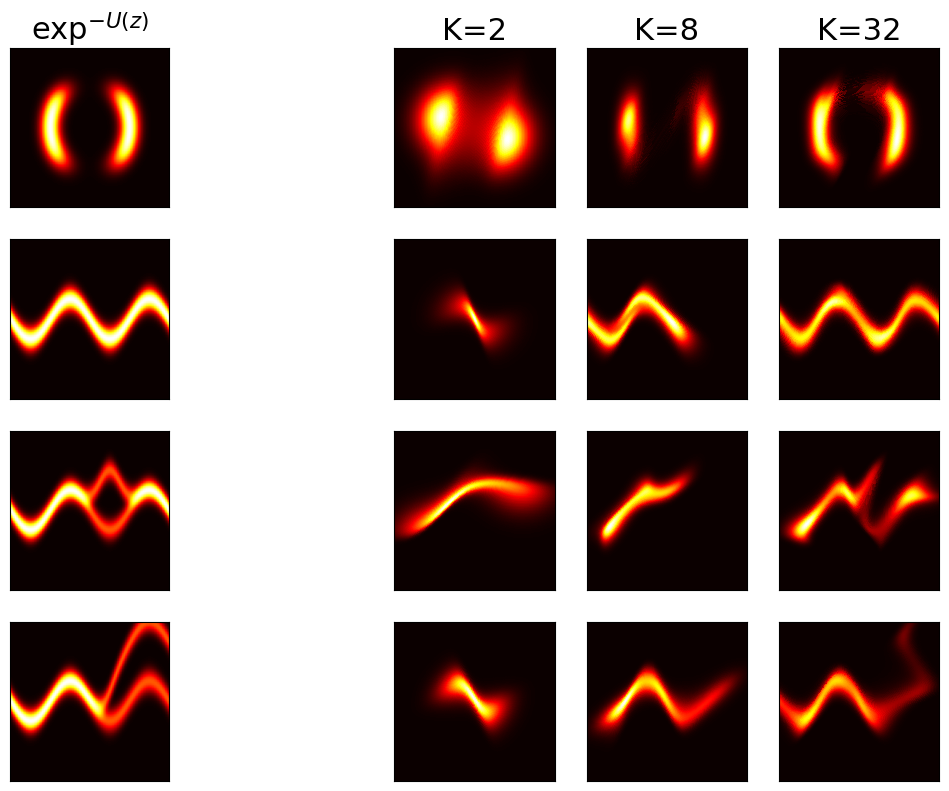

In [10]:
w1 = lambda z: torch.sin((2 * np.pi * z[:, 0]) / 4)
w2 = lambda z: 3 * torch.exp(-(((z[:, 0] - 1) / 0.6) ** 2) / 2)
w3 = lambda z: 3 * 1 / (1 + torch.exp(- ((z[:, 0] - 1) / 0.3)))

# Energy functions
U1 = lambda z: (((torch.sqrt(z[:, 0] ** 2 + z[:, 1] ** 2) - 2) / 0.4) ** 2) / 2 - torch.log(
    1e-15 + (torch.exp(-(((z[:, 0] - 2) / 0.6) ** 2) / 2) + torch.exp(-(((z[:, 0] + 2) / 0.6) ** 2) / 2)))
U2 = lambda z: (((z[:, 1] - w1(z)) / 0.4) ** 2) / 2
U3 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.35) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2) / 2))
U4 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.4) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2) / 2))

if __name__ == "__main__":
    device = 'cuda'; data_dim = 2; index = 1

    plt.figure(figsize=(12, 12))

    for U in [U1, U2, U3, U4]:
        exact_log_density = lambda z: - U(z)

        # Plot the exact density
        ax = plt.subplot(5, 5, index); plt.xticks([], []); plt.yticks([], [])
        plot_exact_density(ax, exact_log_density, title=r'$\exp^{-U(z)}$' if index == 1 else None)
        index += 2

        for flow_length in [2, 8, 32]:
            flow = NormalizingFlow(flow_length, data_dim).to(device)
            # optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
            optimizer = optim.RMSprop(flow.parameters(), lr=1e-5, momentum=0.9)
            loss = train(flow, optimizer, 20000, exact_log_density, 4096, data_dim)
                
            with open('variational_inference_with_normalizing_flows/NF_weight_{}_{}.pth'.format(exact_log_density, flow_length),'wb') as f:
                pickle.dump(flow.state_dict(), f)

            # Plot the learned density
            ax = plt.subplot(5, 5, index); plt.xticks([], []); plt.yticks([], [])
            plot_flow_density(flow, ax, title=f'K={flow_length}' if index <= 5 else None)
            index += 1
    # plt.savefig('Imgs/learned_densities.pdf')
    plt.show()